In [2]:
# !pip3 install SALib

**LET'S IMPORT OUR LIBRARIES**

In [3]:
###############
## imports  ##
##############

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from tqdm.notebook import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import openpyxl
from IPython.display import clear_output
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.figsize"] = (10, 6)
import warnings
warnings.filterwarnings("ignore")

**LET'S READ OUR POPULATION DATA**

In [4]:
# Import population estimates from Excel file
population_data = pd.read_excel("age_data_2005.xls", sheet_name="both; 1950-2005, estimates")

# Filter data to include only Nigeria's population (Country code 566)
# Replace missing values (denoted by "-") with numpy's nan (Not a Number)
nigeria_data = population_data[population_data["Country code"]==566].replace("-", np.nan).reset_index(drop=True)

# Define age groups in 5-year increments (up to age 99), and a final group for ages 100 and above
age_groups = [f"{age*5} - {(age+1)*5-1}" for age in range(20)] + ["100+"]

# Define survival rates for each age group (based on the defined age groups)
survival_rate_groups = [f"Survival Rate: {age*5} - {(age+1)*5-1}" for age in range(1,20)] + ["Survival Rate: 100+"]

# Retrieve and sort unique years from the dataset
data_years = np.sort(nigeria_data["Year"].unique())

# Compute survival rates for each age group in each year by dividing the current population by the previous year's
# Note: The .values method returns a numpy representation of the DataFrame, which is needed for the division operation
nigeria_data.loc[
    nigeria_data["Year"].isin(data_years[1:]),
    survival_rate_groups
] = nigeria_data[
    nigeria_data["Year"].isin(data_years[1:])
][age_groups[1:]].values / nigeria_data[
    nigeria_data["Year"].isin(data_years[:-1])
][age_groups[:-1]].values


In [5]:
# Reading the male population data
male_data = pd.read_excel("age_data_2005.xls", sheet_name="m; 1950-2005, estimates")

# Filtering the data for Nigeria
male_data = male_data[male_data["Country code"]==566].replace("-", np.nan).reset_index(drop=True)

# Calculating the survival rate for each age group and each year, for the male population
male_data.loc[male_data["Year"].isin(data_years[1:]), survival_rate_groups] = male_data[
    male_data["Year"].isin(data_years[1:])
][age_groups[1:]].values / male_data[male_data["Year"].isin(data_years[:-1])][age_groups[:-1]].values


In [6]:
# Reading the female population data
female_data = pd.read_excel("age_data_2005.xls", sheet_name="f; 1950-2005, estimates")

# Filtering the data for Nigeria
female_data = female_data[female_data["Country code"]==566].replace("-", np.nan).reset_index(drop=True)

# Calculating the survival rate for each age group and each year, for the female population
female_data.loc[female_data["Year"].isin(data_years[1:]), survival_rate_groups] = female_data[
    female_data["Year"].isin(data_years[1:])
][age_groups[1:]].values / female_data[female_data["Year"].isin(data_years[:-1])][age_groups[:-1]].values


In [7]:
# Age groups able to give birth
birth_group_start, birth_group_end = 4, 8 

# Calculating the fertility rate for each year, for the female population
female_data["FertilityRate"] = female_data[age_groups[0]] / female_data[age_groups[birth_group_start:birth_group_end]].sum(axis=1)

**Ranges for our models parameters**

In [8]:
# Initializing lists to hold minimum and maximum survival rates
min_survival_rate_list, max_survival_rate_list = [], []

# Calculating the minimum and maximum survival rates for each age group

for group in age_groups[1:]:
  min_survival_rate_list.append(min(male_data[f'Survival Rate: {group}'].min(), female_data[f'Survival Rate: {group}'].min()))
  max_survival_rate_list.append(max(male_data[f'Survival Rate: {group}'].max(), female_data[f'Survival Rate: {group}'].max()))

# Creating dictionaries to hold the minimum and maximum survival rates for each age group

min_survival_rate = dict(zip(age_groups[1:], min_survival_rate_list))
max_survival_rate = dict(zip(age_groups[1:], max_survival_rate_list))

print(f"Minimum survival rate: {min_survival_rate} \n Maximum survival rate: {max_survival_rate}")


Minimum survival rate: {'5 - 9': 0.8651501749098148, '10 - 14': 0.9538465738962658, '15 - 19': 0.9645665855235832, '20 - 24': 0.9496470274380377, '25 - 29': 0.9380366092401502, '30 - 34': 0.9049427058257101, '35 - 39': 0.8984911282740471, '40 - 44': 0.9075819086686159, '45 - 49': 0.9115864182866658, '50 - 54': 0.894414222513518, '55 - 59': 0.8674418604651163, '60 - 64': 0.8259357976198827, '65 - 69': 0.7638129913648666, '70 - 74': 0.6680142223954021, '75 - 79': 0.5408383534136547, '80 - 84': 0.4602022711142655, '85 - 89': 0.24258052367851204, '90 - 94': 0.21320453663374875, '95 - 99': 0.11538461538461539, '100+': 0.05475504322766571} 
 Maximum survival rate: {'5 - 9': 0.9236074414961848, '10 - 14': 0.9737797510651705, '15 - 19': 0.987978665314343, '20 - 24': 0.9924650757613519, '25 - 29': 0.9922242247056099, '30 - 34': 0.9991405123517892, '35 - 39': 0.9859127024676472, '40 - 44': 0.9630859999826353, '45 - 49': 0.9553425595308743, '50 - 54': 0.9458060234267545, '55 - 59': 0.923366256724

In [9]:
# Calculating the minimum and maximum fertility rates
min_fertility_rate, max_fertility_rate = female_data["FertilityRate"].min(), female_data["FertilityRate"].max()
print(f"Fertility rate min: {min_fertility_rate}\nFertility rate max: {max_fertility_rate}")


Fertility rate min: 0.5810394233184736
Fertility rate max: 0.6931237469684394


In [10]:
# Calculating the ratio of boys to girls for each year
boys_girls_ratio = male_data[age_groups[0]] / female_data[age_groups[0]]

# Calculating the minimum and maximum boys to girls ratios
min_boys_girls_ratio, max_boys_girls_ratio = boys_girls_ratio.min(), boys_girls_ratio.max()
print(f"Boys/Girls ratio min: {min_boys_girls_ratio}\nBoys/Girls ratio max: {max_boys_girls_ratio}")

Boys/Girls ratio min: 1.006543874369337
Boys/Girls ratio max: 1.0522630461444524


**Visualization functions for sensitivity and uncertainty analysis results**

In [11]:
def plot_sensitivity_analysis(parameters, dataframe):
    """Plot sensitivity analysis results"""
    
    # Extract age groups from column names
    age_groups = [column.replace("FertilityRate_", "") for column in dataframe.columns if "FertilityRate" in column]
    
    # Create a subplot for each age group
    num_age_groups = len(age_groups)
    figure, axes = plt.subplots(num_age_groups, figsize=(20, 8*num_age_groups))
    
    # Adjust font dictionary
    font = {'size': 14}
    
    # Loop through each age group and plot the sensitivity results
    for index, age_group in enumerate(age_groups):
        # Get the current axis
        axis = axes[index]
        
        # Set title and labels with increased font size
        axis.set_title(f"Age Group: {age_group}", fontsize=25, fontdict=font)
        axis.set_xlabel("Year", fontsize=20, fontdict=font)
        axis.set_ylabel("S1", fontsize=20, fontdict=font)
        axis.set_xticks(range(min(dataframe["year"]), max(dataframe["year"]) + 1, 5))  # Set x-axis to show specific years
        
        # Plot each parameter for the current age group
        colors = plt.get_cmap("cool")(np.linspace(0, 1, len(parameters)))  # Use "cool" colormap for variation
        for parameter_index, parameter in enumerate(parameters):
            axis.plot(dataframe["year"], dataframe[f"{parameter}_{age_group}"], linewidth=2.5, label=f"{parameter}", color=colors[parameter_index])
        
        # Add grid and legend to the plot
        axis.grid(True, linestyle='--', alpha=0.6)
        axis.legend(fontsize=12)
    
    plt.show()


In [12]:
def plot_uncertainty_results(output, age_group_indices, percentile_alphas=[0.8, 0.5, 0.3]):
    """Plot uncertainty results"""
    
    # Create a subplot for each group of age groups
    num_subplots = len(age_group_indices)
    figure, axes = plt.subplots(num_subplots, figsize=(20, 8*num_subplots))
    
    # Adjust font dictionary
    font = {'size': 14}
    
    # Loop through each group of age groups and plot the uncertainty results
    for subplot_index, group_indices in enumerate(age_group_indices):
        # Get the current axis
        try:
            axis = axes[subplot_index]
        except TypeError:
            axis = axes
        
        # Loop through each age group in the current group
        colors = plt.get_cmap("cool")(np.linspace(0, 1, len(group_indices)))  # Use "cool" colormap for variation
        for color_index, group_index in enumerate(group_indices):
            # Set color and get age group
            color = colors[color_index]
            age_group = output["age_groups"][group_index]
            
            # Plot mean and fill between percentiles
            mean_values = output["datasets"][group_index,:,:].mean(axis=-2)
            axis.plot(output["years"], mean_values, linewidth=2.5, label=f"{age_group}", color=color)
            for percentile_index, percentile in enumerate(list(output["percentiles"].keys())):
                lower_bound = output["percentiles"][percentile][group_index][0]
                upper_bound = output["percentiles"][percentile][group_index][1]
                axis.fill_between(output["years"], lower_bound, upper_bound, color=color, alpha=percentile_alphas[percentile_index], label=f"{age_group}: {percentile}% interval")
            
            # Set labels with increased font size
            axis.set_xlabel("Years", fontsize=20, fontdict=font)
            axis.set_ylabel("Population", fontsize=20, fontdict=font)
            axis.set_xticks(range(min(output["years"]), max(output["years"]) + 1, 5))  # Set x-axis to show specific years

            # Add grid and legend to the plot
            axis.grid(True, linestyle='--', alpha=0.6)
            axis.legend(fontsize=12)
    
    plt.show()


**SENSITIVITY ANALYSIS BEGINS**

In [13]:
def sensitivity_model(
    initial_female_profile, 
    initial_male_profile, 
    survival_rate, 
    fertility_rate, 
    boy_girl_ratio, 
    age_group, 
    initial_year=2005, 
    num_steps=1
):
    """Model to simulate the sensitivity analysis.
    
    Parameters:
    - initial_female_profile: Initial female population profile.
    - initial_male_profile: Initial male population profile.
    - survival_rate: Survival rate.
    - fertility_rate: Fertility rate.
    - boy_girl_ratio: Boys to girls ratio at birth.
    - age_group: Age group to analyze.
    - initial_year: Initial year of the analysis (default is 2005).
    - num_steps: Number of time steps to simulate (default is 1).
    
    Returns:
    - Population of the selected age group at the end of the simulation.
    """
    
    # Define the age group indices for the fertility rate calculation
    fertile_age_group_start, fertile_age_group_end = 4, 8
    
    # Initialize the current profiles and year
    current_female_profile = initial_female_profile
    current_male_profile = initial_male_profile
    current_year = initial_year
    
    # Loop over the time steps
    for step in range(num_steps):
        # Update the female profile
        next_female_profile = np.zeros_like(current_female_profile)
        next_female_profile[1:] = survival_rate * current_female_profile[:-1]
        next_female_profile[0] = fertility_rate * current_female_profile[fertile_age_group_start:fertile_age_group_end].sum()
        current_female_profile = next_female_profile

        # Update the male profile
        next_male_profile = np.zeros_like(current_male_profile)
        next_male_profile[1:] = survival_rate * current_male_profile[:-1]
        next_male_profile[0] = next_female_profile[0] * boy_girl_ratio
        current_male_profile = next_male_profile

        # Update the year
        current_year += 5
    
    # Combine the final male and female profiles and return the population of the selected age group
    final_profile = current_female_profile + current_male_profile
    return final_profile[age_groups.index(age_group)]


In [48]:
# Assuming the 2005 profiles are at the last row of your data
initial_female_profile = female_data.loc[female_data["Year"]==2005, age_groups].values[0]
initial_male_profile = male_data.loc[male_data["Year"]==2005, age_groups].values[0]


In [52]:
female_data.loc[female_data["Year"]==2005]

Index    Variant   Region  Notes  Country code  Year      0 - 4     5 - 9  \
11     64  Estimates  Nigeria    NaN           566  2005  10845.139  9257.342   

     10 - 14   15 - 19  ...  Survival Rate: 60 - 64  Survival Rate: 65 - 69  \
11  8280.587  7242.218  ...                0.891944                0.846108   

    Survival Rate: 70 - 74  Survival Rate: 75 - 79  Survival Rate: 80 - 84  \
11                0.772685                 0.67099                0.536749   

    Survival Rate: 85 - 89  Survival Rate: 90 - 94  Survival Rate: 95 - 99  \
11                0.391028                0.259961                0.157414   

    Survival Rate: 100+  FertilityRate  
11             0.089825       0.609255  

[1 rows x 48 columns]

In [14]:
def evaluate_sensitivity(parameter_sets, model, show_progress=False, model_args={}):
    """Evaluate a model over multiple parameter sets.
    
    Parameters:
    - parameter_sets: Parameter sets to evaluate.
    - model: Model to evaluate.
    - show_progress: Whether to show a progress bar (default is False).
    - model_args: Additional arguments for the model (default is an empty dict).
    
    Returns:
    - Array of model results for each parameter set.
    """
    results = []
    for parameter_set in tqdm(parameter_sets, total=len(parameter_sets), leave=show_progress):
        model_args["survival_rate"] = parameter_set[2:]
        model_args["fertility_rate"] = parameter_set[0]
        model_args["boy_girl_ratio"] = parameter_set[1]
        results.append(model(**model_args))
    return np.array(results)

In [15]:
def analyze_sensitivity(age_group, problem_definition, model_args, model, evaluator, 
                        num_parameter_values=1000, max_time_steps=9, show_progress=False):
    """Perform a sensitivity analysis for a given age group.
    
    Parameters:
    - age_group: Age group to analyze.
    - problem_definition: Definition of the problem for the sensitivity analysis.
    - model_args: Arguments for the model.
    - model: Model to analyze.
    - evaluator: Function to evaluate the model.
    - num_parameter_values: Number of parameter values to sample (default is 1000).
    - max_time_steps: Maximum number of time steps (default is 9).
    - show_progress: Whether to show a progress bar (default is False).
    
    Returns:
    - Results of the sensitivity analysis.
    """
    results = []
    model_args["age_group"] = age_group
    parameter_values = saltelli.sample(problem_definition, num_parameter_values)
    years = [model_args["initial_year"]]
    
    for num_steps in tqdm(range(1, max_time_steps+1), leave=show_progress):  
        model_args["num_steps"] = num_steps
        years.append(years[-1] + 5)
        model_results = evaluate_sensitivity(parameter_values, model, model_args=model_args)
        sensitivity_indices = sobol.analyze(problem_definition, model_results, print_to_console=False)
        results.append(sensitivity_indices["S1"])
    
    results = np.array(results)
    results = dict(zip(problem_definition["names"], results.T))
    results["year"] = years[1:]
    
    return results

In [16]:
def perform_full_sensitivity_analysis(problem_definition, model_args, model, evaluator, 
                                      num_parameter_values=1000, max_time_steps=9):
    """Perform a full sensitivity analysis for all age groups.
    
    Parameters:
    - problem_definition: Definition of the problem for the sensitivity analysis.
    - model_args: Arguments for the model.
    - model: Model to analyze.
    - evaluator: Function to evaluate the model.
    - num_parameter_values: Number of parameter values to sample (default is 1000).
    - max_time_steps: Maximum number of time steps (default is 9).
    
    Returns:
    - Dataframe of the sensitivity analysis results for each age group.
    """
    results = pd.DataFrame()
    results["year"] = [model_args["initial_year"] + step*5 for step in range(1, max_time_steps+1)]
    model_args["num_steps"] = max_time_steps
    
    for age_group in tqdm(age_groups[1:age_groups.index("45 - 49") + 1]):
        age_group_results = analyze_sensitivity(
            age_group, problem_definition, model_args, model, evaluator, 
            num_parameter_values=num_parameter_values, max_time_steps=max_time_steps
        )
        for name in problem_definition["names"]:
            results[f"{name}_{age_group}"] = age_group_results[name]
    
    return results

In [17]:
# Age groups capable of giving birth
birth_capable_start, birth_capable_end = 4, 8

# Define survival rate column names
survival_rate_columns = [f'Survival Rate: {age_group}' for age_group in age_groups[1:]]

# Calculate mean survival rates for female and male data for the year 2005
average_survival_rate_female = female_data[female_data["Year"]==2005][survival_rate_columns].mean(axis=0).values
average_survival_rate_male = male_data[male_data["Year"]==2005][survival_rate_columns].mean(axis=0).values

# Select initial profiles for female and male data for the year 2005
initial_profile_female = female_data[female_data["Year"]==2005][age_groups].values.reshape(-1)
initial_profile_male = male_data[male_data["Year"]==2005][age_groups].values.reshape(-1)

# Calculate the ratio of boys to girls for the year 2005
boy_girl_ratio_2005 = (male_data[male_data["Year"]==2005][age_groups[0]] / female_data[
    female_data["Year"]==2005
][age_groups[0]]).values[0]

# Select the fertility rate coefficient for the year 2005
fertility_rate_coefficient = female_data["FertilityRate"][11]


In [18]:
# Define parameter names
parameter_names = ["FertilityRate", "BoysToGirlsRatio"] + [f"SurvivalRate({k})" for k in min_survival_rate.keys()]

# Define problem for Sobol sensitivity analysis
problem = {
    "num_vars": len(parameter_names),
    "names": parameter_names,
    "bounds": [[min_fertility_rate, max_fertility_rate], 
               [min_boys_girls_ratio, max_boys_girls_ratio]] + list(zip(min_survival_rate.values(), max_survival_rate.values()))
}

# Define model arguments
model_arguments = {
    "initial_female_profile": initial_profile_female, 
    "initial_male_profile": initial_profile_male, 
    "initial_year": 2005
}
  

# Perform Sobol sensitivity analysis and store results in a DataFrame
sensitivity_analysis_results = perform_full_sensitivity_analysis(problem, model_arguments, sensitivity_model, evaluate_sensitivity, num_parameter_values=1000, max_time_steps=9)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

In [19]:
sensitivity_analysis_results.to_excel("sensitivity_analysis_results.xlsx")

In [20]:
# Read back the data
sensitivity_analysis_results = pd.read_excel("sensitivity_analysis_results.xlsx")

In [21]:
for s in sensitivity_analysis_results.columns:
  print(s)

Unnamed: 0
year
FertilityRate_5 - 9
BoysToGirlsRatio_5 - 9
SurvivalRate(5 - 9)_5 - 9
SurvivalRate(10 - 14)_5 - 9
SurvivalRate(15 - 19)_5 - 9
SurvivalRate(20 - 24)_5 - 9
SurvivalRate(25 - 29)_5 - 9
SurvivalRate(30 - 34)_5 - 9
SurvivalRate(35 - 39)_5 - 9
SurvivalRate(40 - 44)_5 - 9
SurvivalRate(45 - 49)_5 - 9
SurvivalRate(50 - 54)_5 - 9
SurvivalRate(55 - 59)_5 - 9
SurvivalRate(60 - 64)_5 - 9
SurvivalRate(65 - 69)_5 - 9
SurvivalRate(70 - 74)_5 - 9
SurvivalRate(75 - 79)_5 - 9
SurvivalRate(80 - 84)_5 - 9
SurvivalRate(85 - 89)_5 - 9
SurvivalRate(90 - 94)_5 - 9
SurvivalRate(95 - 99)_5 - 9
SurvivalRate(100+)_5 - 9
FertilityRate_10 - 14
BoysToGirlsRatio_10 - 14
SurvivalRate(5 - 9)_10 - 14
SurvivalRate(10 - 14)_10 - 14
SurvivalRate(15 - 19)_10 - 14
SurvivalRate(20 - 24)_10 - 14
SurvivalRate(25 - 29)_10 - 14
SurvivalRate(30 - 34)_10 - 14
SurvivalRate(35 - 39)_10 - 14
SurvivalRate(40 - 44)_10 - 14
SurvivalRate(45 - 49)_10 - 14
SurvivalRate(50 - 54)_10 - 14
SurvivalRate(55 - 59)_10 - 14
SurvivalRat

In [22]:
age_groups

['0 - 4',
 '5 - 9',
 '10 - 14',
 '15 - 19',
 '20 - 24',
 '25 - 29',
 '30 - 34',
 '35 - 39',
 '40 - 44',
 '45 - 49',
 '50 - 54',
 '55 - 59',
 '60 - 64',
 '65 - 69',
 '70 - 74',
 '75 - 79',
 '80 - 84',
 '85 - 89',
 '90 - 94',
 '95 - 99',
 '100+']

In [23]:
# Iterate over each age group
for age_group in age_groups:
    # Create a list of column names containing the term 'SurvivalRate' and the current age group
    survival_rate_cols = [col for col in sensitivity_analysis_results.columns if ("SurvivalRate" in col) and (f"_{age_group}" in col)]
    
    # Calculate the sum of the sensitivity values across the columns in survival_rate_cols
    summed_survival_rate_sensitivity = sensitivity_analysis_results[survival_rate_cols].sum(axis=1)
    
    # Drop the original 'SurvivalRate' columns for the current age group from the dataframe
    sensitivity_analysis_results = sensitivity_analysis_results.drop(survival_rate_cols, axis=1)
    
    # Add a new column with the summed sensitivity values for the current age group
    sensitivity_analysis_results[f"SurvivalRate_{age_group}"] = summed_survival_rate_sensitivity


In [24]:
sensitivity_analysis_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                9 non-null      int64  
 1   year                      9 non-null      int64  
 2   FertilityRate_5 - 9       9 non-null      float64
 3   BoysToGirlsRatio_5 - 9    9 non-null      float64
 4   FertilityRate_10 - 14     9 non-null      float64
 5   BoysToGirlsRatio_10 - 14  9 non-null      float64
 6   FertilityRate_15 - 19     9 non-null      float64
 7   BoysToGirlsRatio_15 - 19  9 non-null      float64
 8   FertilityRate_20 - 24     9 non-null      float64
 9   BoysToGirlsRatio_20 - 24  9 non-null      float64
 10  FertilityRate_25 - 29     9 non-null      float64
 11  BoysToGirlsRatio_25 - 29  9 non-null      float64
 12  FertilityRate_30 - 34     9 non-null      float64
 13  BoysToGirlsRatio_30 - 34  9 non-null      float64
 14  FertilityRate_

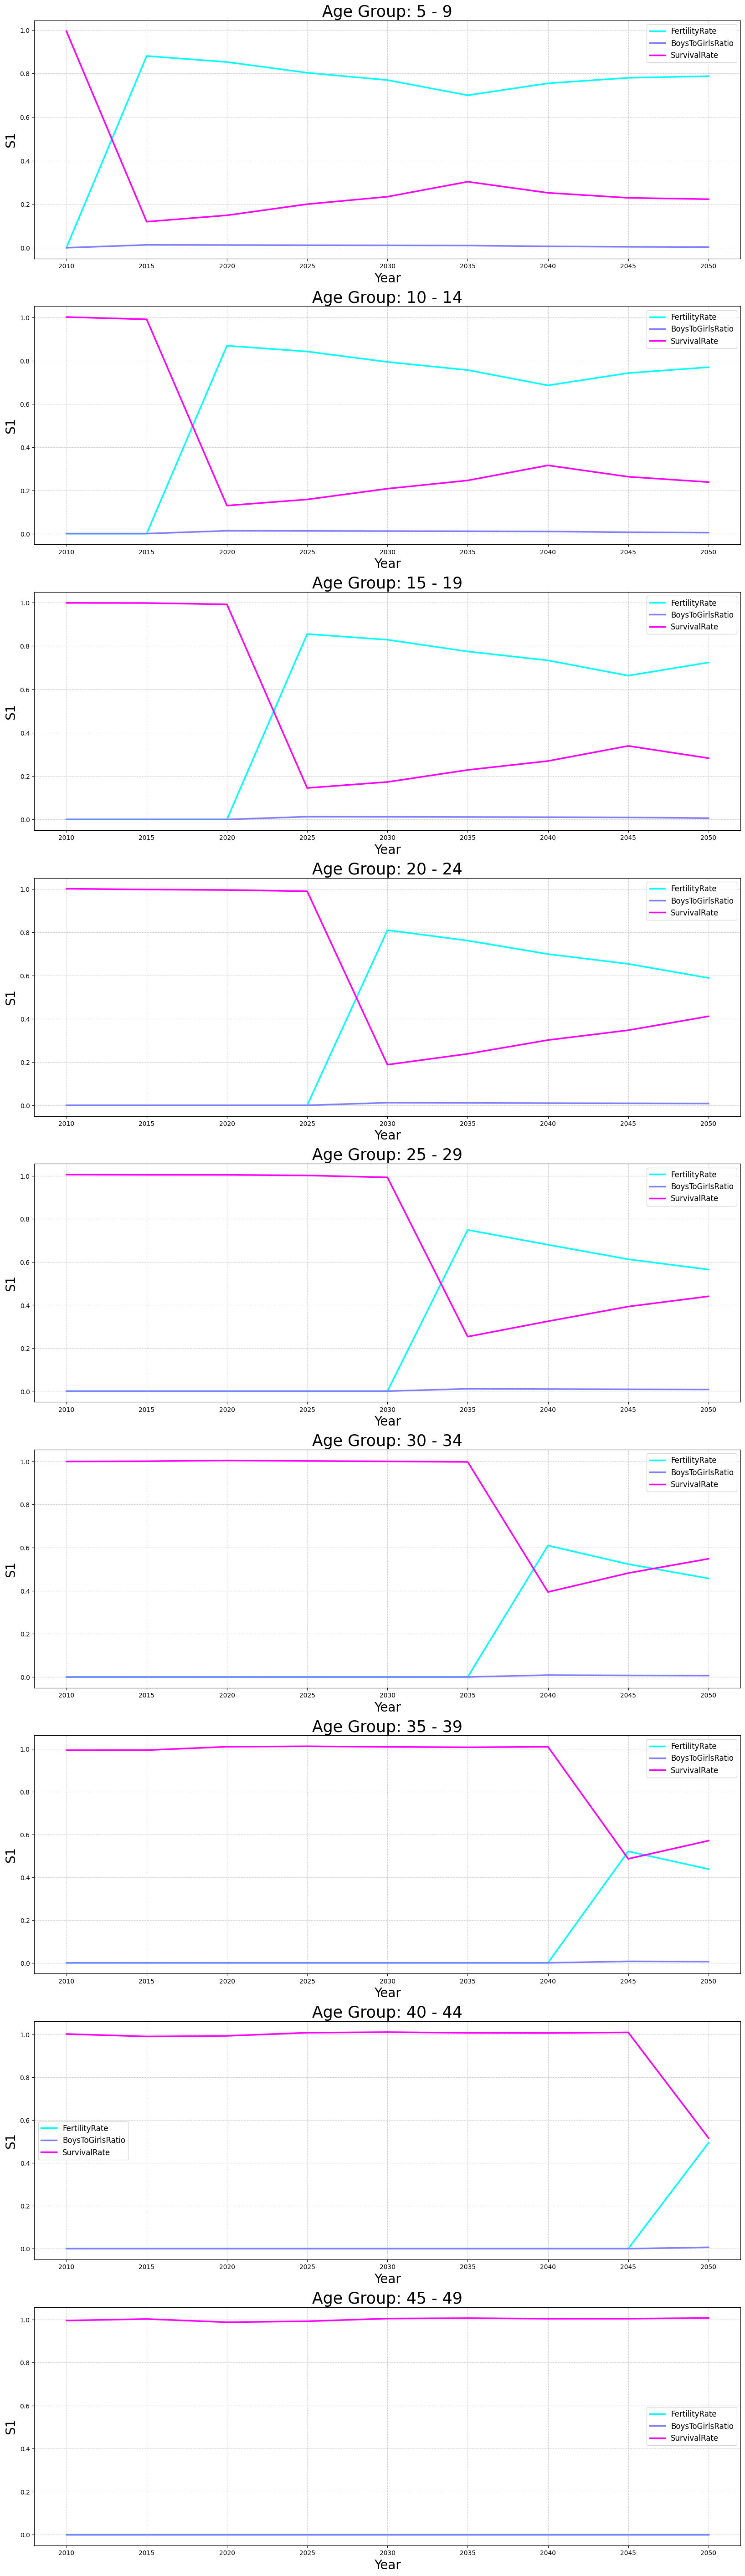

In [25]:
plot_sensitivity_analysis(["FertilityRate", "BoysToGirlsRatio", "SurvivalRate"], sensitivity_analysis_results)

In [26]:
import seaborn as sns

def plot_heatmap_sensitivity(dataframe):
    """Plot sensitivity analysis results using a heatmap"""
    
    # Extract age groups from column names
    age_groups = [column.replace("FertilityRate_", "") for column in dataframe.columns if "FertilityRate" in column]
    
    # Loop through each age group and plot the sensitivity results
    for age_group in age_groups:
        # Create a new dataframe for the current age group
        heatmap_data = dataframe[[column for column in dataframe.columns if f"_{age_group}" in column]].copy()
        
        # Rename the columns to remove the age group suffix
        heatmap_data.columns = [column.replace(f"_{age_group}", "") for column in heatmap_data.columns]
        
        # Create a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0, vmax=1)
        plt.title(f"Age Group: {age_group}", fontsize=25)
        plt.show()


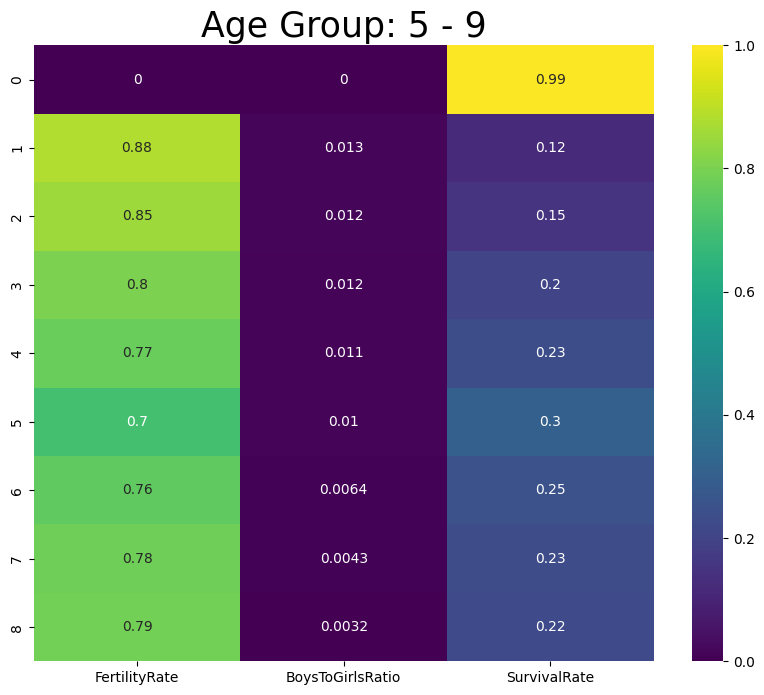

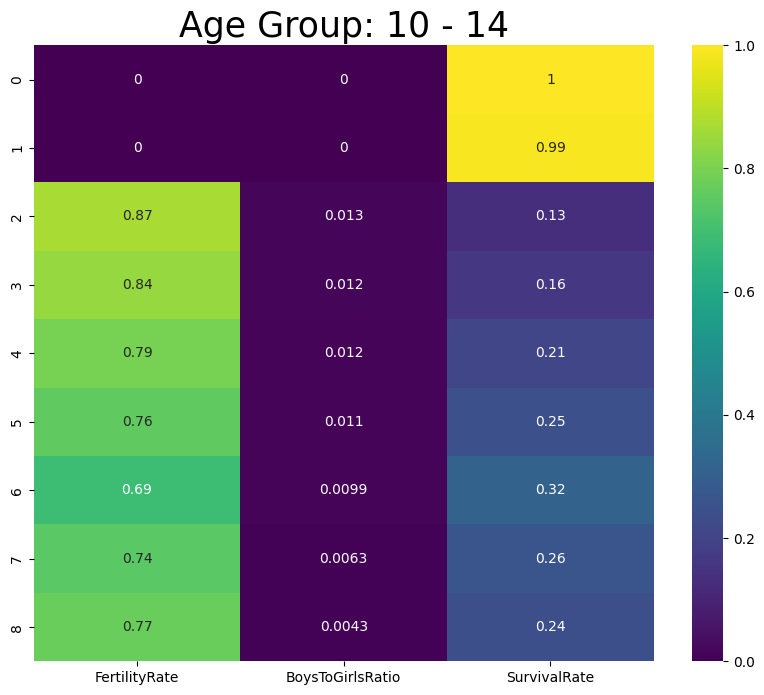

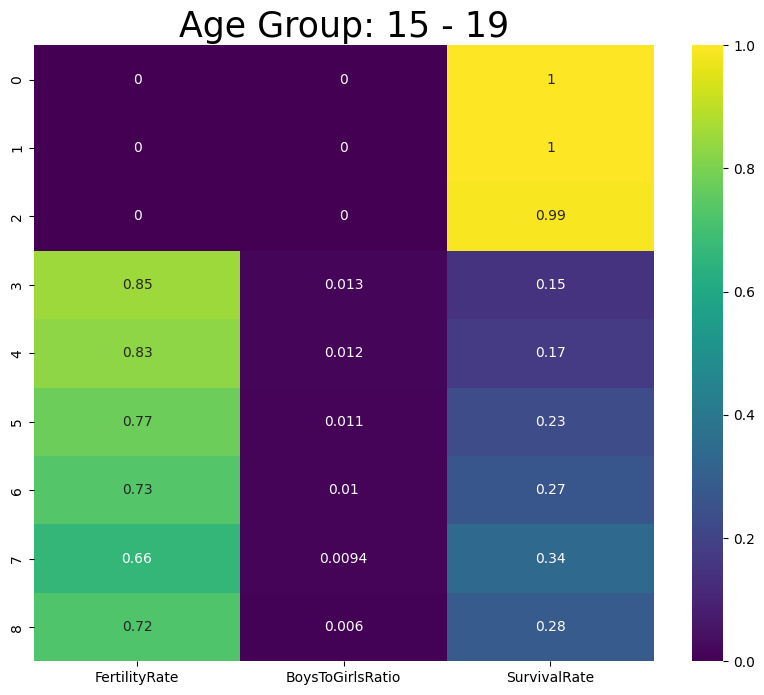

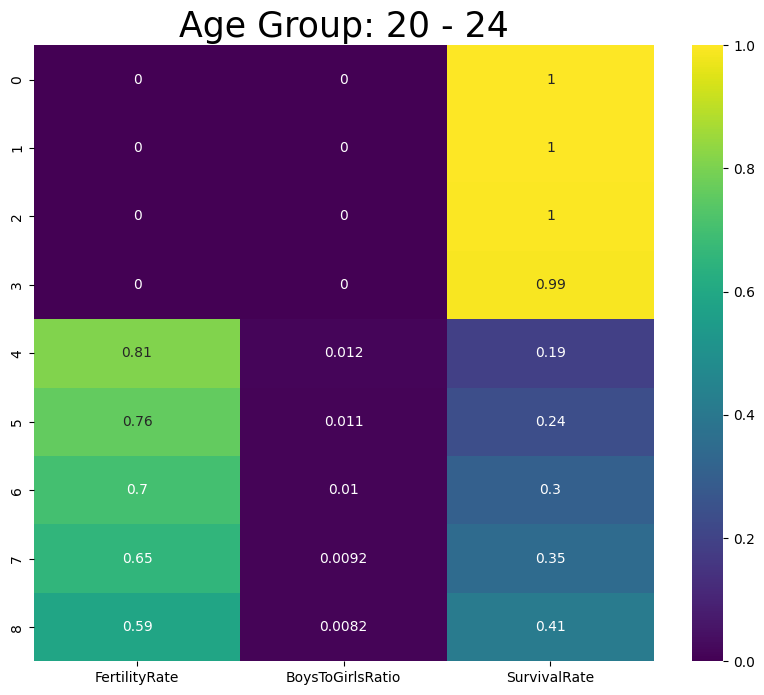

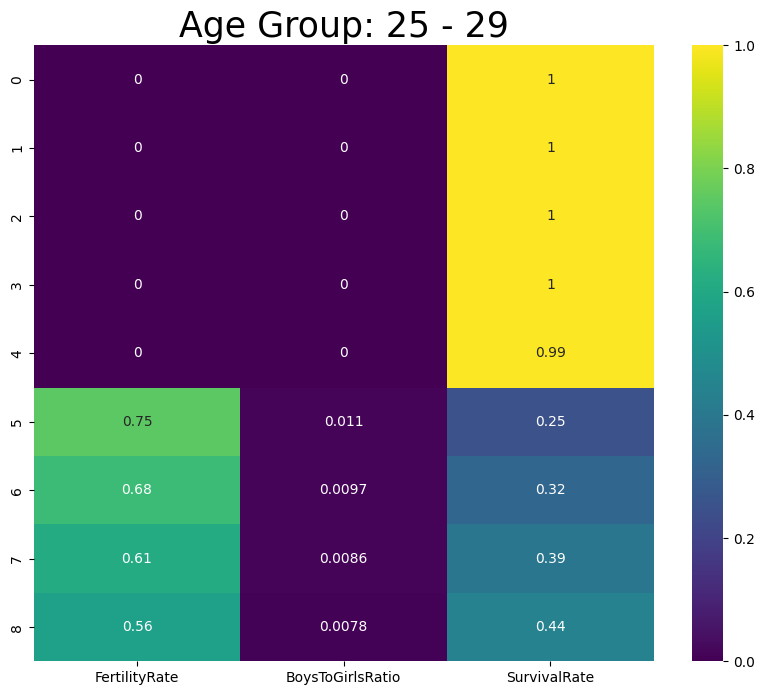

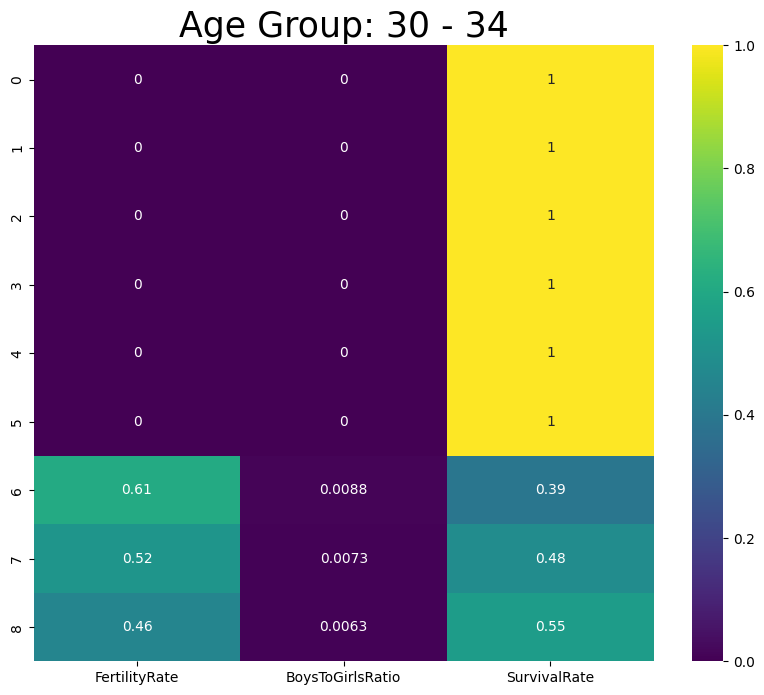

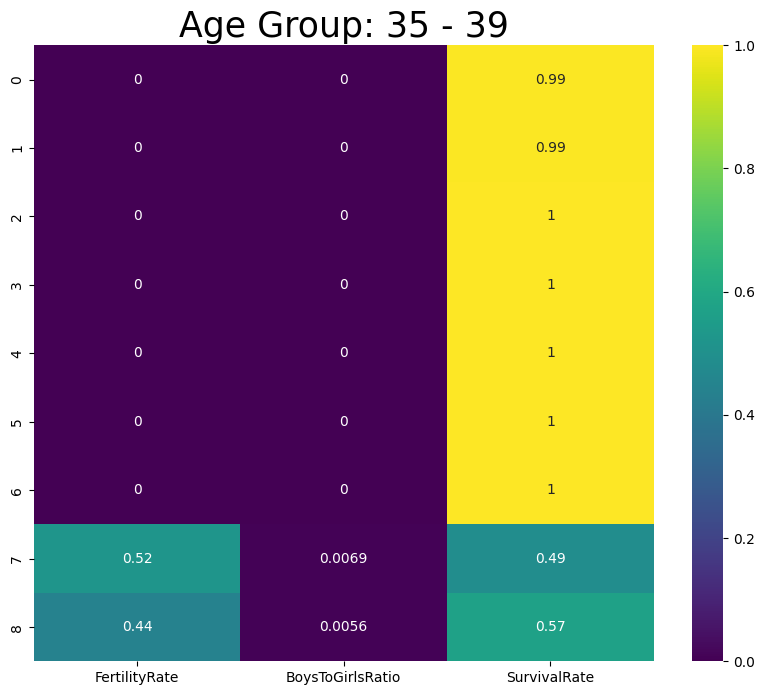

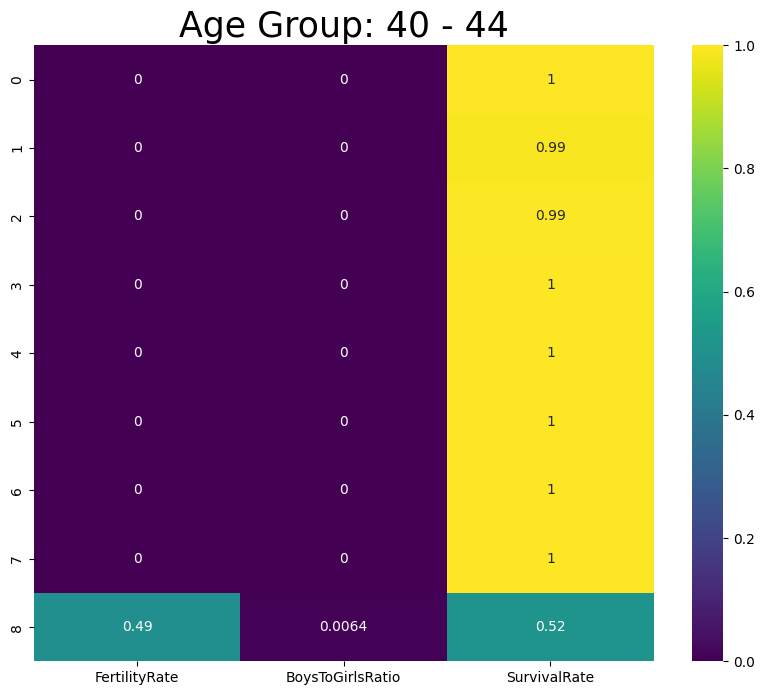

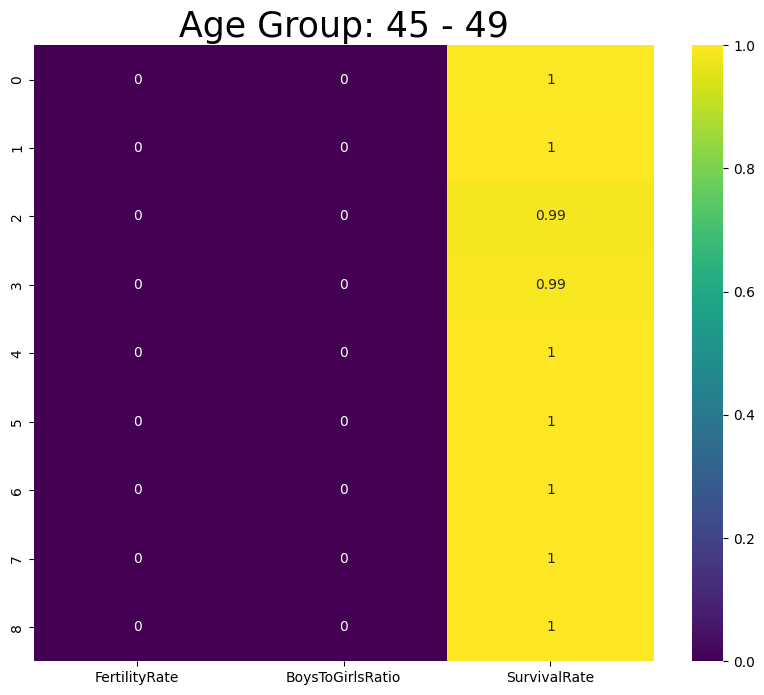

In [27]:
plot_heatmap_sensitivity(sensitivity_analysis_results)

In [28]:
import seaborn as sns

def plot_pairwise_scatter(dataframe):
    """Plot pairwise scatter plots for sensitivity analysis results"""
    
    # Extract age groups from column names
    age_groups = [column.replace("FertilityRate_", "") for column in dataframe.columns if "FertilityRate" in column]
    
    # Loop through each age group and plot the sensitivity results
    for age_group in age_groups:
        # Create a new dataframe for the current age group
        scatter_data = dataframe[[column for column in dataframe.columns if f"_{age_group}" in column]].copy()
        
        # Rename the columns to remove the age group suffix
        scatter_data.columns = [column.replace(f"_{age_group}", "") for column in scatter_data.columns]
        
        # Create a pairwise scatter plot
        sns.pairplot(scatter_data)
        plt.suptitle(f"Age Group: {age_group}", fontsize=25, y=1.02)  # Adjust y value to place title above plots
        plt.show()


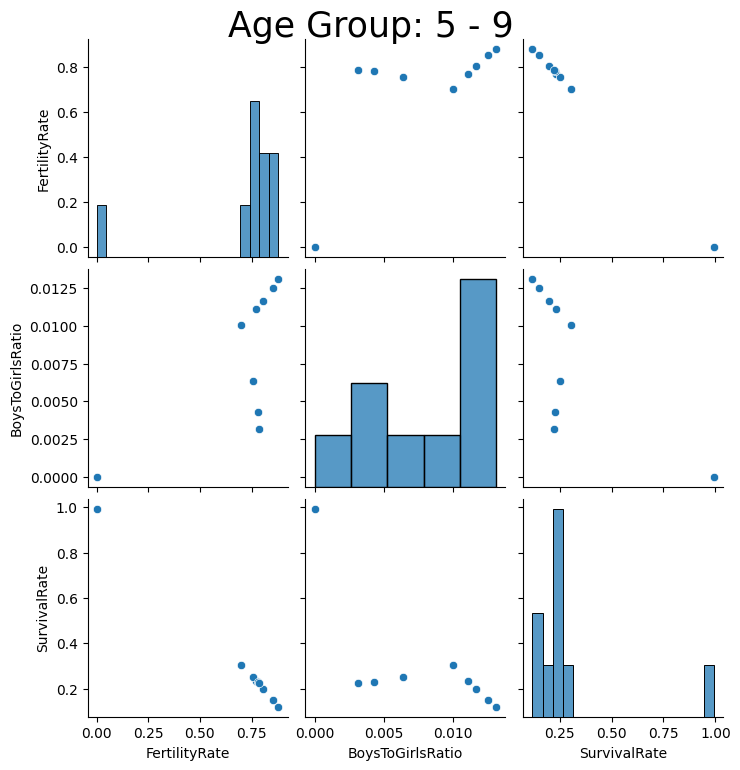

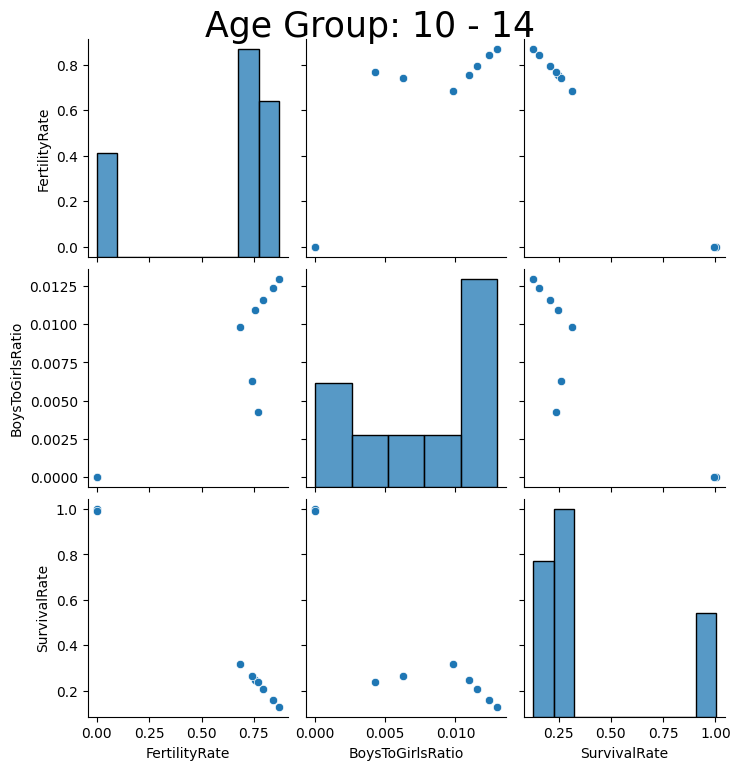

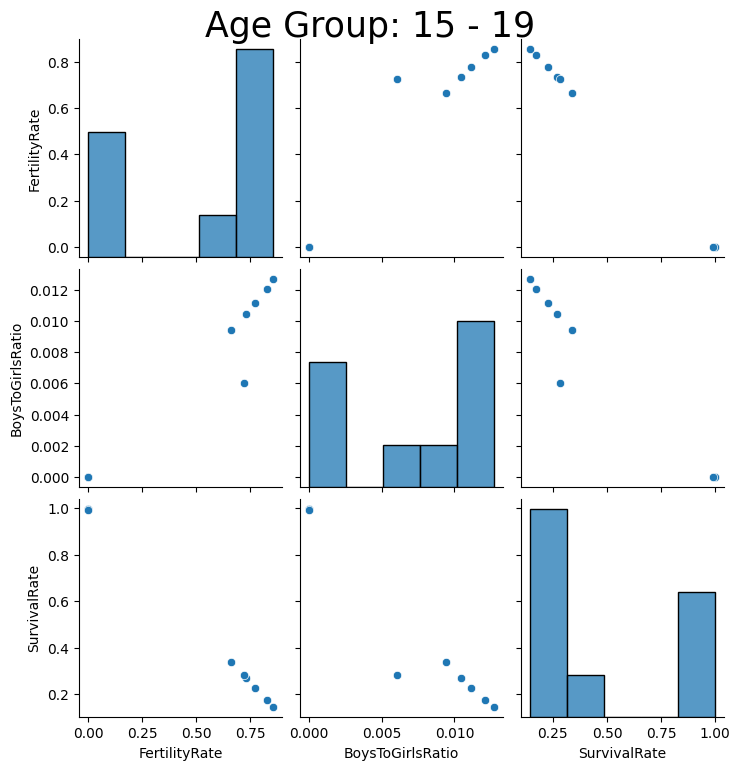

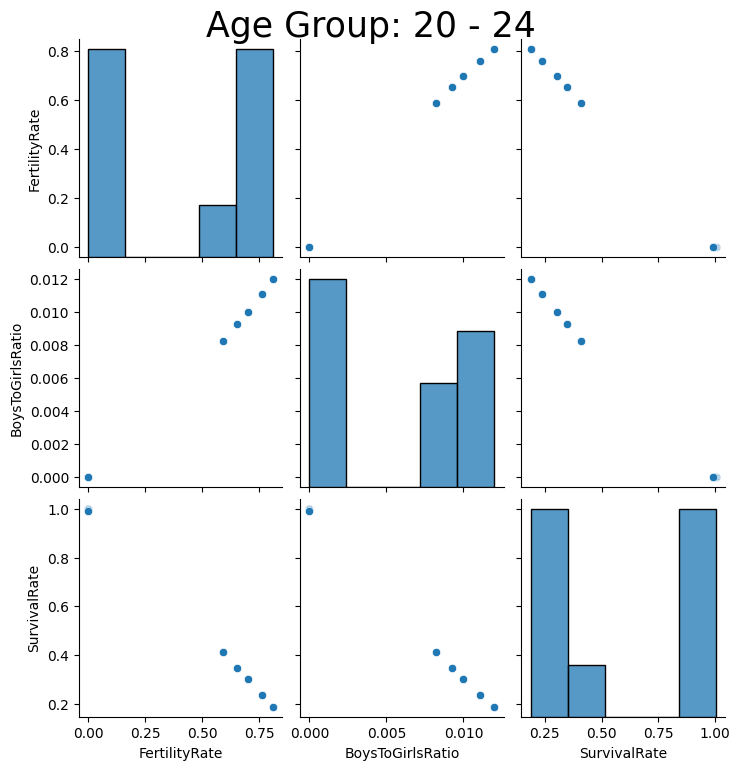

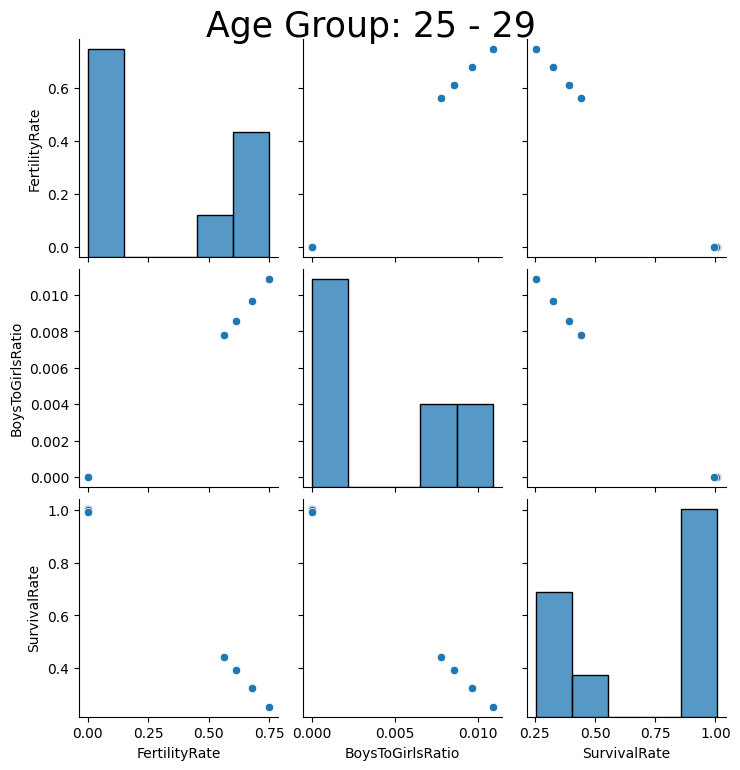

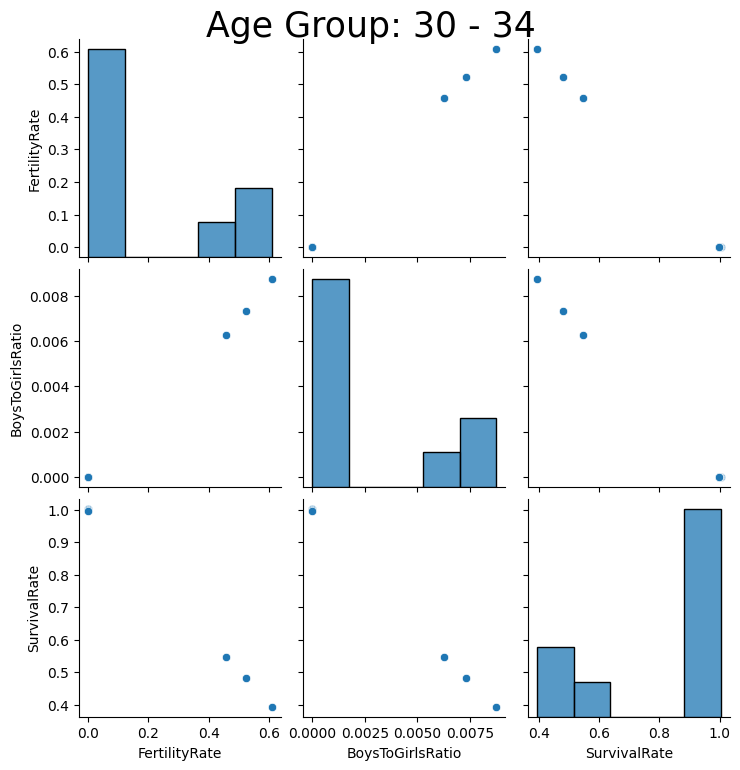

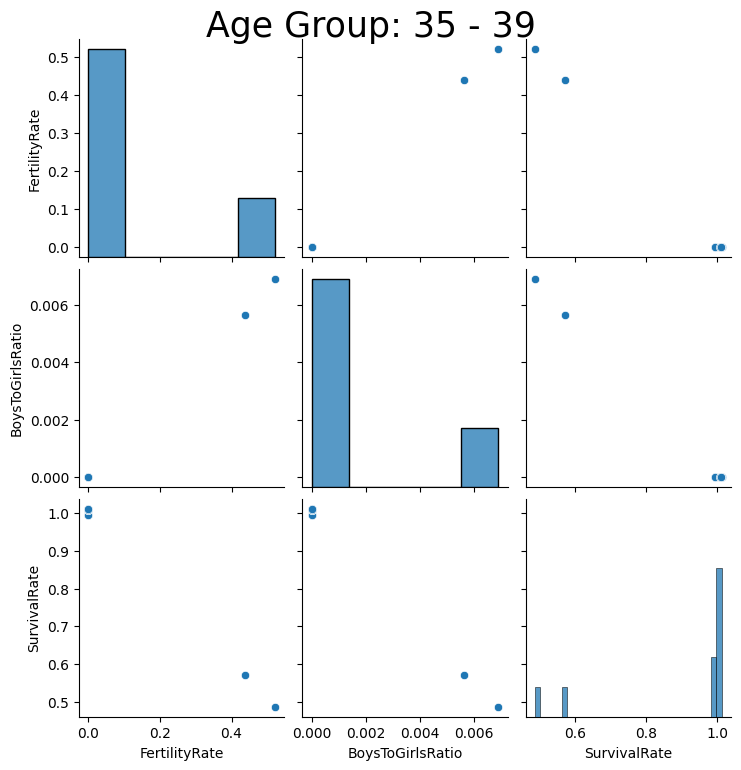

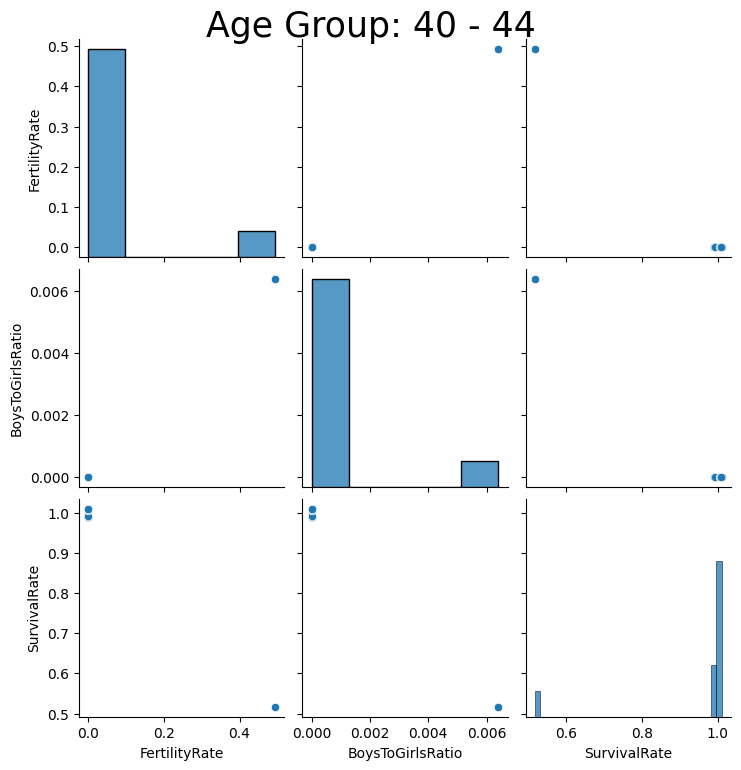

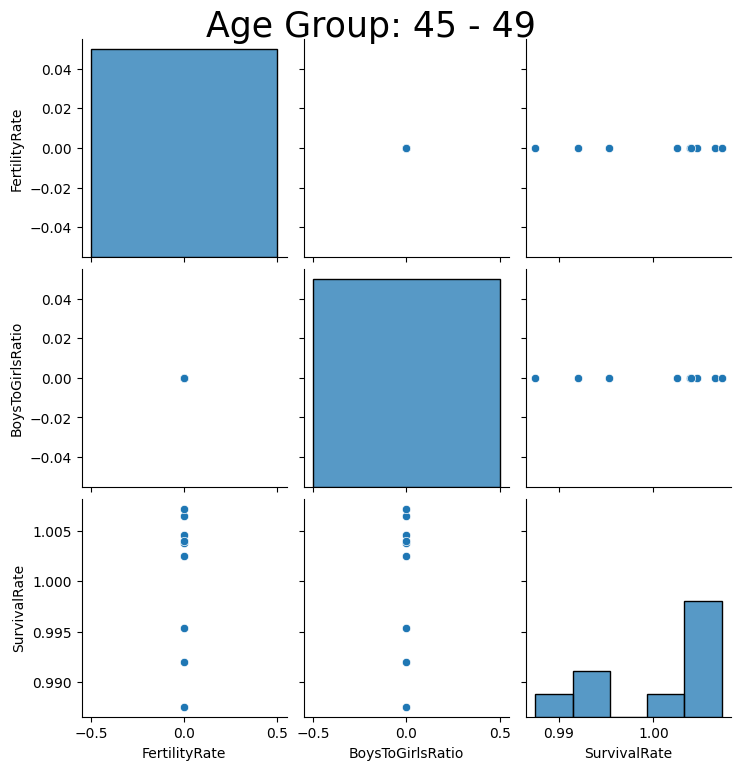

In [29]:
plot_pairwise_scatter(sensitivity_analysis_results)

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radial(dataframe):
    """Plot radial plots for sensitivity analysis results"""
    
    # Extract age groups from column names
    age_groups = [column.replace("FertilityRate_", "") for column in dataframe.columns if "FertilityRate" in column]
    
    # Loop through each age group and plot the sensitivity results
    for age_group in age_groups:
        # Create a new dataframe for the current age group
        radial_data = dataframe[[column for column in dataframe.columns if f"_{age_group}" in column]].copy()
        
        # Rename the columns to remove the age group suffix
        radial_data.columns = [column.replace(f"_{age_group}", "") for column in radial_data.columns]
        
        # Number of variables
        num_vars = len(radial_data.columns)

        # Compute angle of each axis
        angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
        angles += angles[:1]

        # Initialise the spider plot
        ax = plt.subplot(111, polar=True)

        # Draw one axis per variable + add labels
        plt.xticks(angles[:-1], radial_data.columns, color='grey', size=8)

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
        plt.ylim(0,1)

        # Plot each row
        for index, row in radial_data.iterrows():
            values=row.values.flatten().tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=1, linestyle='solid', label=index)
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        plt.title(f"Age Group: {age_group}", size=20, color='grey', y=1.1)
        
        plt.show()

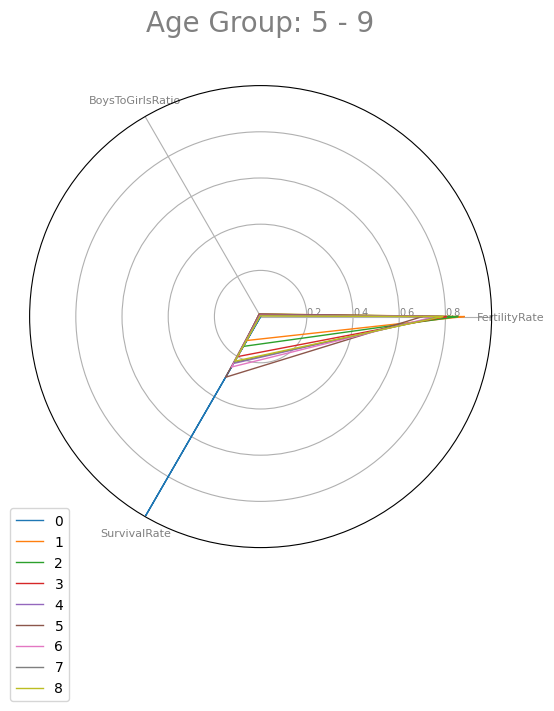

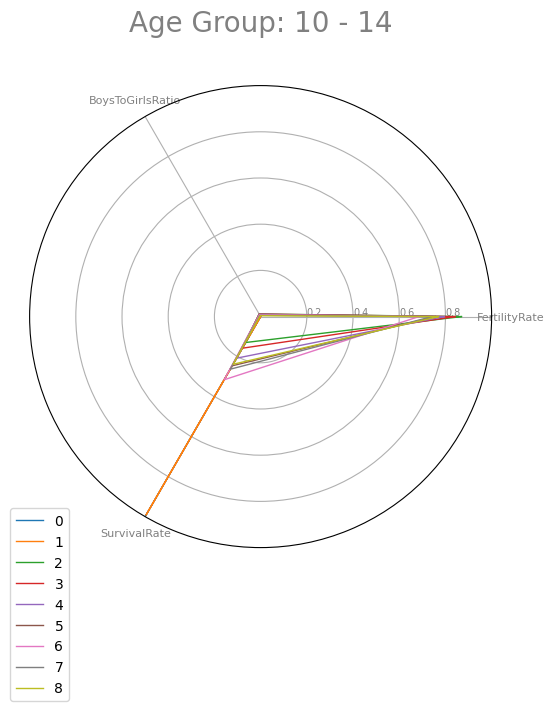

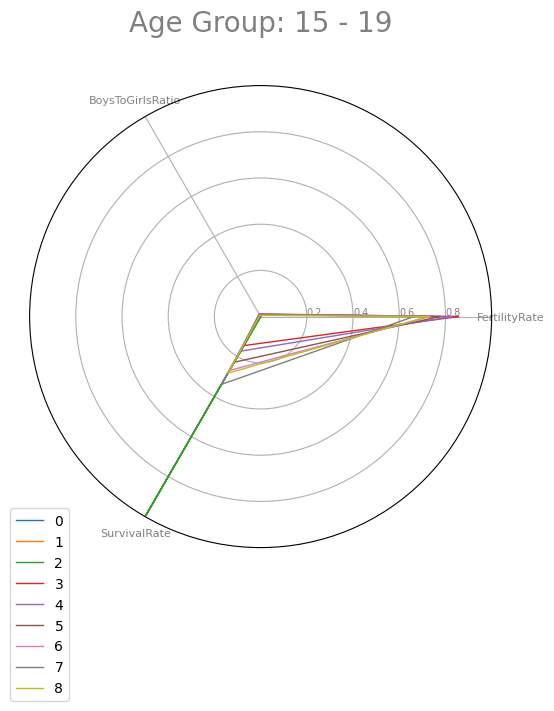

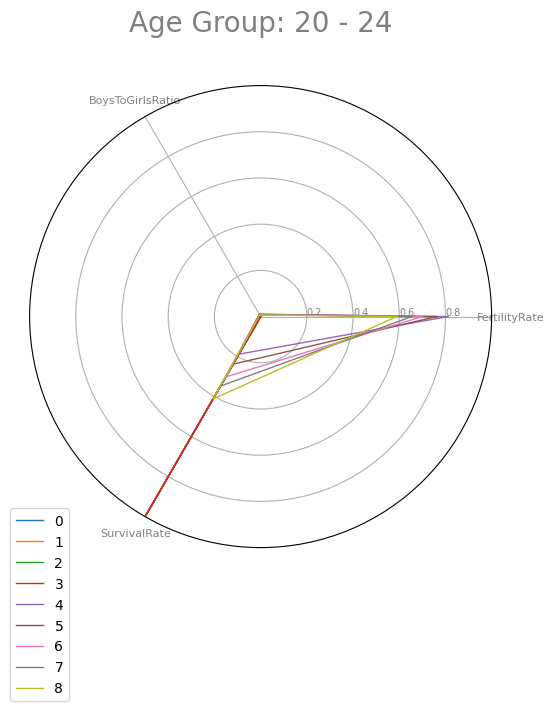

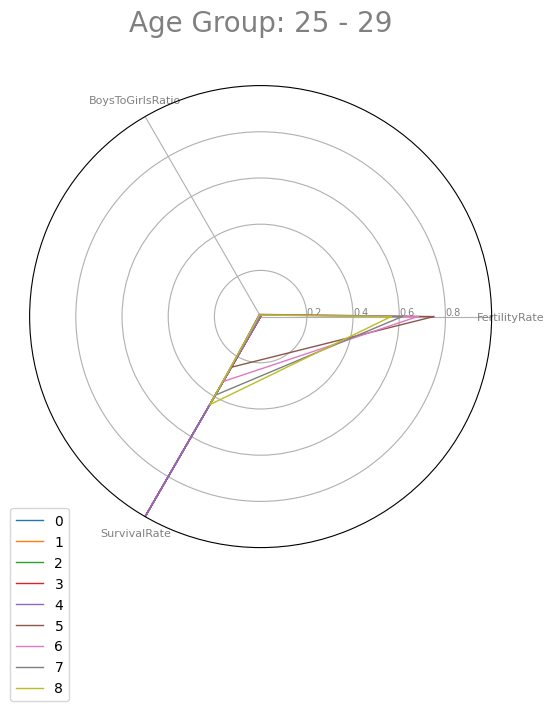

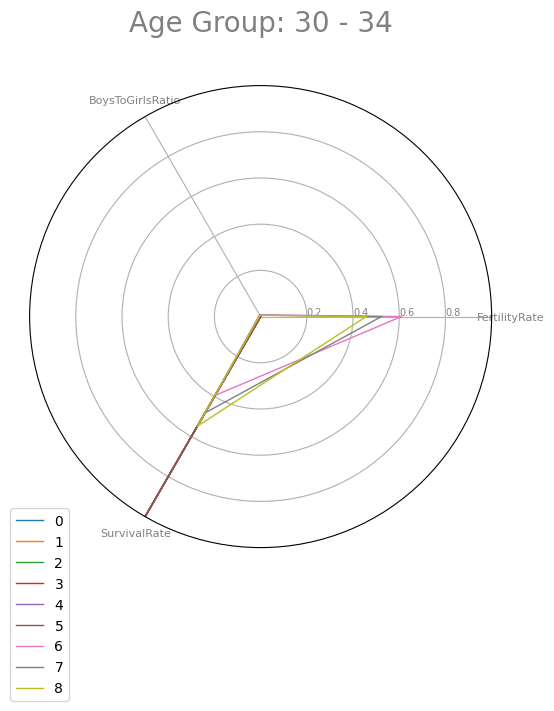

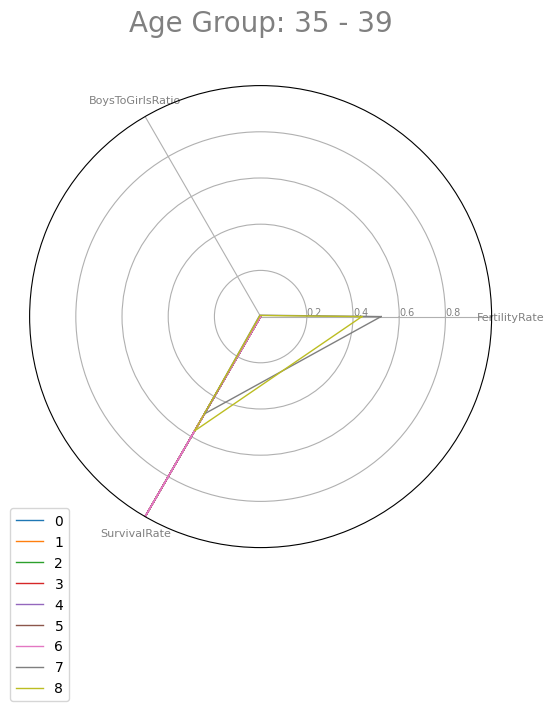

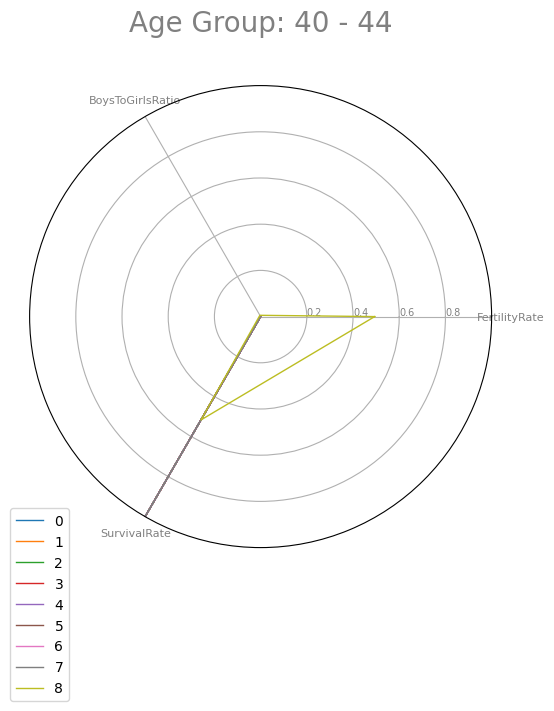

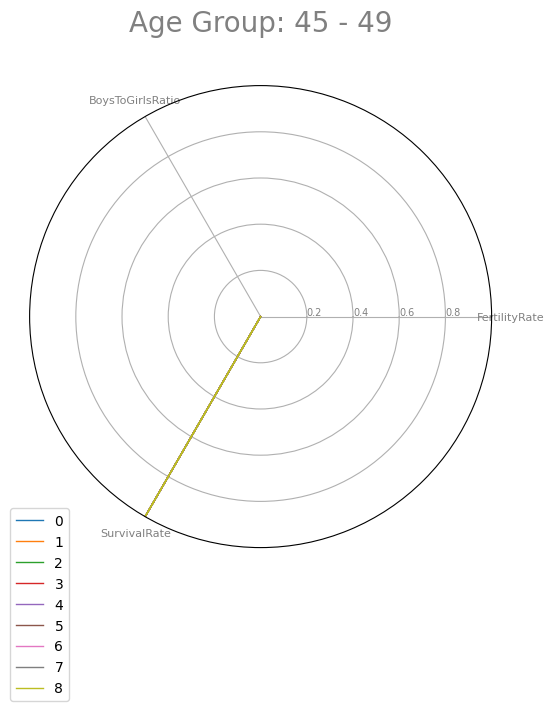

In [31]:
# Plot the radial charts for the first timestep
plot_radial(sensitivity_analysis_results)

**UNCERTAINTY ANALYSIS**

In [32]:
def uncertainty_model(
    initial_female_profile,
    initial_male_profile,
    survival_rate,
    fertility_rate,
    boys_to_girls_ratio,
    age_group=None,
    initial_year=2005,
    num_steps=1
):
    """Model to simulate the uncertainty analysis.

    Parameters:
    - initial_female_profile: Initial female population profile.
    - initial_male_profile: Initial male population profile.
    - survival_rate: Survival rate.
    - fertility_rate: Fertility rate.
    - boys_to_girls_ratio: Boys to girls ratio at birth.
    - age_group: Age group to analyze.
    - initial_year: Initial year of the analysis (default is 2005).
    - num_steps: Number of time steps to simulate (default is 1).

    Returns:
    - Population profile for all the age groups at the end of the simulation.
    """
    
    # Define the age group indices for the fertility rate calculation
    fertile_age_group_start, fertile_age_group_end = 4, 8

    # Initialize the current profiles
    current_female_profile = initial_female_profile
    current_male_profile = initial_male_profile
    
    # Create a list to hold the combined population profiles at each time step
    profiles = []

    # Loop over the time steps
    for step in range(num_steps):
        # Update the female profile
        next_female_profile = np.zeros_like(current_female_profile)
        next_female_profile[1:] = survival_rate * current_female_profile[:-1]
        next_female_profile[0] = fertility_rate * current_female_profile[fertile_age_group_start:fertile_age_group_end].sum()
        current_female_profile = next_female_profile

        # Update the male profile
        next_male_profile = np.zeros_like(current_male_profile)
        next_male_profile[1:] = survival_rate * current_male_profile[:-1]
        next_male_profile[0] = next_female_profile[0] * boys_to_girls_ratio
        current_male_profile = next_male_profile

        # Store the combined profile of the current time step
        profiles.append(current_female_profile + current_male_profile)

    # Convert the profiles list into a numpy array
    profiles_array = np.array(profiles)

    # Return the population profile for the selected age group at each time step
    return profiles_array[:, age_groups.index(age_group)]


In [33]:
def perform_uncertainty_analysis(
    age_group, 
    problem, 
    model_arguments, 
    uncertainty_model, 
    num_parameter_values=1000, 
    max_time_steps=9, 
    show_progress=False
):
    """Perform uncertainty analysis for a given age group.

    Parameters:
    - age_group: Age group to analyze.
    - problem: Problem definition for the uncertainty analysis.
    - model_arguments: Arguments to pass to the uncertainty model.
    - uncertainty_model: Model to simulate the uncertainty analysis.
    - num_parameter_values: Number of parameter value samples to generate (default is 1000).
    - max_time_steps: Maximum number of time steps to simulate (default is 9).
    - show_progress: Whether to show a progress bar (default is False).

    Returns:
    - Population profile for the selected age group at each time step for each parameter value sample.
    """
    
    # Create an empty list to hold the population profiles
    population_profiles = []

    # Generate samples of the parameter values
    parameter_value_samples = saltelli.sample(problem, num_parameter_values)

    # Set the age group and the number of time steps in the model arguments
    model_arguments["age_group"] = age_group
    model_arguments["num_steps"] = max_time_steps

    # Loop over the parameter value samples
    for parameter_values in tqdm(parameter_value_samples, total=len(parameter_value_samples), leave=show_progress):
        # Set the fertility rate, boys to girls ratio, and survival rate in the model arguments
        model_arguments["fertility_rate"] = parameter_values[0]
        model_arguments["boys_to_girls_ratio"] = parameter_values[1]
        model_arguments["survival_rate"] = parameter_values[2:]

        # Run the uncertainty model with the current parameter values and append the resulting population profile to the list
        population_profiles.append(uncertainty_model(**model_arguments))

    # Convert the population profiles list into a numpy array and return it
    return np.array(population_profiles)


In [34]:
def perform_full_uncertainty_analysis(
    age_groups, 
    problem, 
    model_arguments, 
    uncertainty_model, 
    num_parameter_values=1000, 
    max_time_steps=9, 
    show_progress=True
):
    """Perform full uncertainty analysis for a list of age groups.

    Parameters:
    - age_groups: Age groups to analyze.
    - problem: Problem definition for the uncertainty analysis.
    - model_arguments: Arguments to pass to the uncertainty model.
    - uncertainty_model: Model to simulate the uncertainty analysis.
    - num_parameter_values: Number of parameter value samples to generate (default is 1000).
    - max_time_steps: Maximum number of time steps to simulate (default is 9).
    - show_progress: Whether to show a progress bar (default is True).

    Returns:
    - Dictionary with the population profiles for each age group at each time step for each parameter value sample,
      the list of age groups, and the list of years corresponding to the time steps.
    """
    
    # Create a dictionary to hold the results
    results = {
        "datasets": [],
        "age_groups": age_groups,
        "years": [model_arguments["initial_year"] + (step+1)*5 for step in range(max_time_steps)]
    }

    # Set the number of time steps in the model arguments
    model_arguments["num_steps"] = max_time_steps

    # Loop over the age groups
    for age_group in tqdm(age_groups, leave=show_progress):
        # Perform uncertainty analysis for the current age group and append the resulting population profiles to the results
        population_profiles = perform_uncertainty_analysis(age_group, problem, model_arguments, uncertainty_model, num_parameter_values=num_parameter_values, max_time_steps=max_time_steps)
        results["datasets"].append(population_profiles)

    # Convert the datasets list into a numpy array
    results["datasets"] = np.array(results["datasets"])

    # Return the results
    return results


In [35]:
def compute_percentiles(uncertainty_results, percentile_intervals):
    """Compute percentiles of the population profiles.

    Parameters:
    - uncertainty_results: Dictionary with the population profiles for each age group at each time step for each parameter value sample.
    - percentile_intervals: List of percentile intervals to compute.

    Returns:
    - Updated dictionary with the computed percentiles.
    """

    # Compute the mean population profile over all parameter value samples for each age group and time step
    total_mean_population_profiles = np.expand_dims(uncertainty_results["datasets"].mean(axis=0), axis=0)

    # Append the mean population profiles to the datasets and "total" to the age groups
    uncertainty_results["datasets"] = np.concatenate([uncertainty_results["datasets"], total_mean_population_profiles], axis=0)
    uncertainty_results["age_groups"].append("total")

    # Initialize the percentiles dictionary
    uncertainty_results["percentiles"] = {}

    # Loop over the percentile intervals
    for percentile_interval in percentile_intervals:
        # Compute the percentiles for each age group and time step and store them in the percentiles dictionary
        uncertainty_results["percentiles"][f"{percentile_interval}"] = [np.percentile(data, [50-percentile_interval/2, 50+percentile_interval/2], axis=0) for data in uncertainty_results["datasets"]]

    # Return the updated dictionary
    return uncertainty_results


In [36]:
# Define parameter names
parameter_names = ["FertilityRate", "BoysToGirlsRatio"] + [f"SurvivalRate({k})" for k in min_survival_rate.keys()]

# Define problem for uncertainty analysis
problem = {
    "num_vars": len(parameter_names),
    "names": parameter_names,
    "bounds": [
        [min_fertility_rate, max_fertility_rate],
        [min_boys_girls_ratio, max_boys_girls_ratio]
    ] + list(zip(min_survival_rate.values(), max_survival_rate.values()))
}

# Define model arguments
model_arguments = {
    "initial_female_profile": initial_profile_female,
    "initial_male_profile": initial_profile_male,
    "initial_year": 2005
}

# Define age groups to analyze
age_groups_to_analyze = age_groups[1:age_groups.index("40 - 44")+1]

# Perform full uncertainty analysis and store results in a dictionary
uncertainty_analysis_results = perform_full_uncertainty_analysis(
    age_groups_to_analyze, 
    problem, 
    model_arguments, 
    uncertainty_model, 
    num_parameter_values=1000, 
    max_time_steps=20
)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

  0%|          | 0/46000 [00:00<?, ?it/s]

In [37]:
uncertainty_analysis_results

{'datasets': array([[[ 19838.28213312,  18661.99334959,  22282.56768685, ...,
           93805.37942043, 102628.32651869, 111186.27863899],
         [ 19838.28213312,  21628.30715609,  25824.36983712, ...,
          148103.4605142 , 165029.888301  , 183759.06598415],
         [ 19838.28213312,  18715.51650768,  22346.47476101, ...,
           94074.41606933, 102922.66764517, 111505.1642295 ],
         ...,
         [ 19312.25634404,  20794.33977336,  24671.49233997, ...,
          128959.8593965 , 142638.01424438, 157398.68786804],
         [ 19312.25634404,  20794.33977336,  24671.49233997, ...,
          128959.8593965 , 142638.01424438, 157398.68786804],
         [ 19312.25634404,  20794.33977336,  24671.49233997, ...,
          128959.8593965 , 142638.01424438, 157398.68786804]],
 
        [[ 18302.76360598,  19115.1841207 ,  17981.77062625, ...,
           81778.42631738,  90386.20819589,  98887.56215077],
         [ 18302.76360598,  19115.1841207 ,  20839.9633967 , ...,
         

In [38]:
# Define percentile intervals for analysis
percentile_intervals = [50, 70, 90]

# Compute percentiles of the results from uncertainty analysis
uncertainty_analysis_results_with_percentiles = compute_percentiles(
    uncertainty_analysis_results, 
    percentile_intervals
)


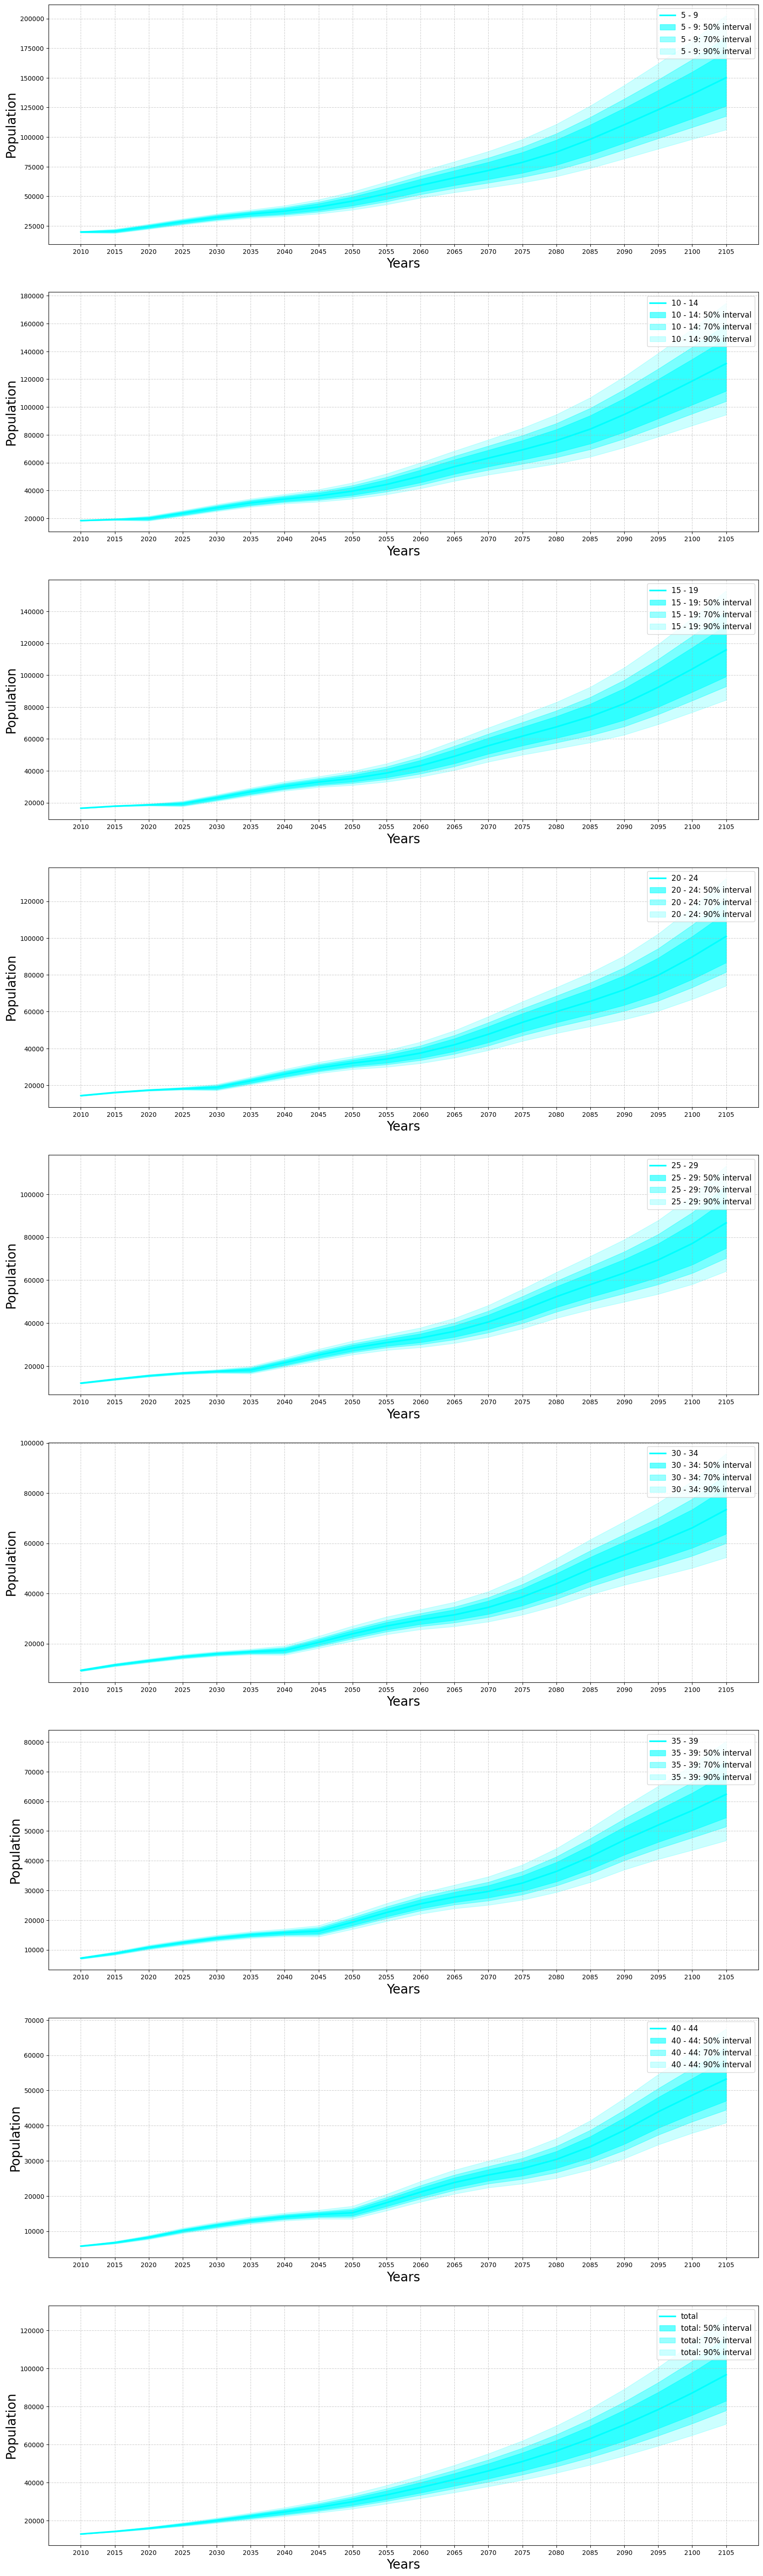

In [39]:
# Define uncertainty levels
uncertainty_levels = [0.6, 0.4, 0.2]

# Plot uncertainty analysis results for each age group
plot_uncertainty_results(
    uncertainty_analysis_results_with_percentiles, 
    [[index] for index in range(len(uncertainty_analysis_results["age_groups"]))], 
    percentile_alphas=uncertainty_levels
)